# Basic Hands-On 2: Neural networks for regression - simple energy reconstruction with TA

We trained a simple model yesterday for the energy reconstruction from TA SD simulation. Today we will revise this task and train one of the proposed architectures we saw today to estimate the energy. No need for visualizing the data today.


### 1. Load data from ascii file 

We load the data as we did before and normalize the input features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from IPython.display import display
from matplotlib.colors import LogNorm

import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

/Users/anatoli/mbp14_def_312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='mps')

In [3]:
class CosmicRayDataset(Dataset):
    def __init__(self, X_data, y_data):
        # Store the input features (X_data) and target values (y_data)
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.X_data)

    def __getitem__(self, index):
        # Retrieve a single sample at the given index
        X_sample = self.X_data[index]
        y_sample = self.y_data[index]
        # return torch.tensor(X_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)
        return X_sample, y_sample

In [4]:
# Load data again in case some variables have been overwritten
data_total_signal = np.loadtxt("../day1/total_signal_prot.txt", comments="#", dtype=np.float32)
data_arrival_times = np.loadtxt("../day1/arrival_times_prot.txt", comments="#", dtype=np.float32)

In [5]:
# Store data in a dictionary
data = dict()
data["energy"] = data_total_signal[:, 1]
data["shower_axis"] = data_total_signal[:, 2:5]
data["total_signal"] = data_total_signal[:, 5:].reshape(-1, 7, 7)
data["arrival_times"] = data_arrival_times[:, 5:].reshape(-1, 7, 7)

data["total_signal"] = (data["total_signal"] - data["total_signal"].min()) / (data["total_signal"].max() - data["total_signal"].min())
data["arrival_times"] = (data["arrival_times"] - data["arrival_times"].min()) / (data["arrival_times"].max() - data["arrival_times"].min())

In [6]:
data["total_signal"].shape

(51653, 7, 7)

In [7]:
def filter_and_transform_data(X, y):
    # Remove NaN, +Inf, -Inf
    y = torch.nan_to_num(y, nan = 0, posinf=0, neginf=0)
    
    # Filter energies in the range [0, 300] EeV
    # Energies should be positive and should not be huge
    mask = (y > 1e-1) & (y < 300)
    X = X[mask]
    
    # Train on log(E)
    y = torch.log(y[mask])
    return X, y

In [8]:
# Reshape total_signal and arrival_time into 2D grids
total_signal = torch.tensor(data["total_signal"], dtype=torch.float32).to(device)  # [batch, 7, 7]
arrival_time = torch.tensor(data["arrival_times"], dtype=torch.float32).to(device)  # [batch, 7, 7]
energy = torch.tensor(data["energy"], dtype=torch.float32).to(device)

# Combine them into a 2-channel tensor
combined_features = torch.stack((total_signal, arrival_time), dim=1)  # Shape: [batch, 2, 7, 7]

# Filter and transform data
combined_features, energy = filter_and_transform_data(combined_features, energy)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, energy, test_size=0.2, random_state=42)

# Update DataLoader with new shapes
train_dataset = CosmicRayDataset(X_train, y_train)
test_dataset = CosmicRayDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 2.  Train and evalulate the model

We are familiar with this step from the previous exercise and will simply take the same model for regression. We use the function from utils and modify it for regression.

In [9]:
def training_monitor(
    device,
    model,
    optimizer,
    criterion,
    num_epochs,
    trainloader,
    testloader,
    plot_interval=1,
    scheduler = None
):

    train_losses = []
    val_losses = []
    bias_history = []
    resolution_history = []


    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    pbar = tqdm(total=num_epochs, leave=True)

    hdisplay_img = display(display_id=True)
    hdisplay_pbar = display(display_id=True)
    title = f"|{'Epoch':^20}|{'Train loss':^20}|{'Validation loss':^20}|{'Bias':^20}|{'Resolution':^20}|"
    print(title)
    print("_" * len(title))

    for epoch in range(num_epochs):
        # Step 3: Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)

        # Step 4: Validation phase
        model.eval()
        val_loss = 0.0
        bias = 0.0
        resolution = 0.0
        outputs_list = []
        labels_list = []
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                outputs_list.append(outputs)
                labels_list.append(labels)

        outputs_list = torch.concatenate(outputs_list)
        labels_list = torch.concatenate(labels_list)
        bias = torch.mean(outputs_list - labels_list)
        resolution = torch.std(outputs_list - labels_list)

        bias_history.append(bias.item())
        resolution_history.append(resolution.item())
        avg_val_loss = val_loss / len(testloader)
        
        if scheduler is not None:
            scheduler.step(avg_val_loss)
        
        val_losses.append(avg_val_loss)

        # tqdm progress bar
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        pbar.update()

        # Plotting updates every `plot_interval` epochs
        if (epoch + 1) % plot_interval == 0:
            # Clear the previous plot
            ax1.clear()
            ax2.clear()
            ax3.clear()

            # Plot training and validation loss
            ax1.plot(range(1, epoch + 2), train_losses, "b-", label="Train Loss")
            ax1.plot(range(1, epoch + 2), val_losses, "r-", label="Val Loss")
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss")
            ax1.set_title("Loss")
            ax1.legend()
            ax1.grid(linestyle="--", linewidth=0.5, alpha=0.5)

            # Plot bias
            ax2.plot(range(1, epoch + 2), bias_history, "g-", label="Validation")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("Bias")
            ax2.set_title("Bias")
            ax2.legend()
            ax2.grid(linestyle="--", linewidth=0.5, alpha=0.5)

            # Plot resolution
            ax3.plot(range(1, epoch + 2), resolution_history, "m-", label="Validation")
            ax3.set_xlabel("Epoch")
            ax3.set_ylabel("Resolution")
            ax3.set_title("Resolution")
            ax3.legend()
            ax3.grid(linestyle="--", linewidth=0.5, alpha=0.5)

            # Update the plot in the notebook
            hdisplay_img.update(fig)
            hdisplay_pbar.update(pbar)

        # Print losses at each epoch
        print(
            f"|{epoch+1:^20}|{train_loss:^20.4f}|{avg_val_loss:^20.4f}| {bias_history[-1]:^20.4f}| {resolution_history[-1]:^20.4f}|"
        )
    plt.tight_layout()
    plt.close()

In [10]:
# Evaluation function
def evaluate_cosmic_ray_model(model, X_test, y_test, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return outputs

# Exercise: 

Take one of the presented architectures and train a model for regression. Evaluate its performance with the training monitor function above and plot predicted energies vs. true energy. Discuss the performance and which steps to take for potential improvement.

This solution tests three different models

a) We take the Residual Block CNN and modify it for our example. Input shapes need to be adjusted carfully.

In [11]:
class SqueezeLayer(nn.Module):
    def forward(self, x):
        return x.squeeze()  # Removes the last dimension if it is 1


# Residual Block example
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# CNN with Residual Blocks
class CNNResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Initial convolution layer (accepting 2 channels: arrival time and total charge)
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # output of each batch is normalized
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Max Pooling for downsampling

            # Residual Block
            ResidualBlock(32),

            # Another downsampling layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Second Residual Block
            ResidualBlock(64),

            # Flatten for output prediction
            nn.Flatten(),

            # Fully connected layers for regression
            nn.Linear(64 * 1 * 1, 128),  # Adjusted for 7x7 input size after pooling
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 1),  # Single output for energy prediction (regression)
            # Squeeze the last dimension to make it (batch_size,) instead of (batch_size, 1)
            SqueezeLayer()
        )

    def forward(self, x):
        return self.model(x)

adapt training monitor function for regression task

  0%|          | 0/30 [00:00<?, ?it/s]

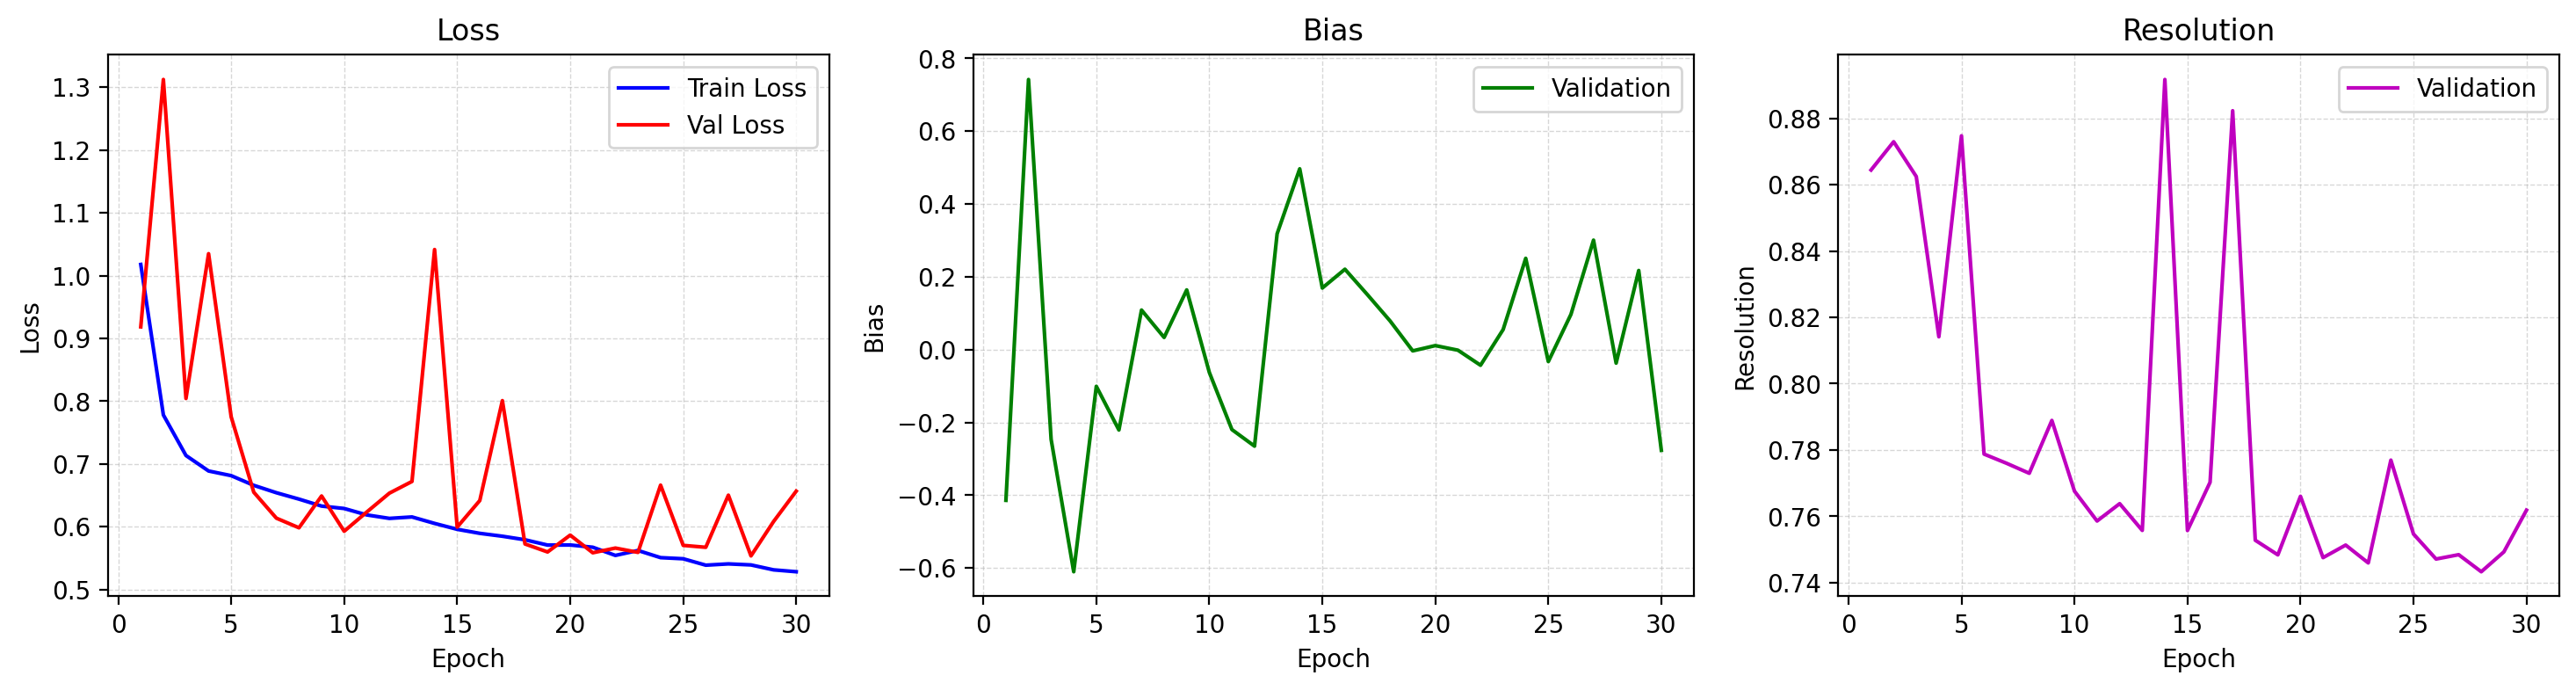

|       Epoch        |     Train loss     |  Validation loss   |        Bias        |     Resolution     |
__________________________________________________________________________________________________________


Epoch 1/30:   3%|▎         | 1/30 [00:11<05:27, 11.30s/it]

|         1          |       1.0177       |       0.9184       |       -0.4141       |        0.8645       |


Epoch 2/30:   7%|▋         | 2/30 [00:17<03:47,  8.13s/it]

|         2          |       0.7781       |       1.3124       |        0.7419       |        0.8730       |


Epoch 3/30:  10%|█         | 3/30 [00:23<03:11,  7.10s/it]

|         3          |       0.7135       |       0.8043       |       -0.2466       |        0.8625       |


Epoch 4/30:  13%|█▎        | 4/30 [00:28<02:52,  6.62s/it]

|         4          |       0.6888       |       1.0349       |       -0.6102       |        0.8141       |


Epoch 5/30:  17%|█▋        | 5/30 [00:34<02:39,  6.37s/it]

|         5          |       0.6814       |       0.7751       |       -0.1009       |        0.8748       |


Epoch 6/30:  20%|██        | 6/30 [00:41<02:31,  6.31s/it]

|         6          |       0.6659       |       0.6550       |       -0.2209       |        0.7787       |


Epoch 7/30:  23%|██▎       | 7/30 [00:47<02:22,  6.18s/it]

|         7          |       0.6542       |       0.6137       |        0.1086       |        0.7760       |


Epoch 8/30:  27%|██▋       | 8/30 [00:52<02:13,  6.05s/it]

|         8          |       0.6440       |       0.5984       |        0.0333       |        0.7730       |


Epoch 9/30:  30%|███       | 9/30 [00:58<02:05,  5.96s/it]

|         9          |       0.6329       |       0.6490       |        0.1639       |        0.7889       |


Epoch 10/30:  33%|███▎      | 10/30 [01:04<01:59,  5.99s/it]

|         10         |       0.6291       |       0.5928       |       -0.0627       |        0.7676       |


Epoch 11/30:  37%|███▋      | 11/30 [01:10<01:53,  6.00s/it]

|         11         |       0.6188       |       0.6234       |       -0.2197       |        0.7586       |


Epoch 12/30:  40%|████      | 12/30 [01:16<01:47,  5.99s/it]

|         12         |       0.6133       |       0.6535       |       -0.2652       |        0.7638       |


Epoch 13/30:  43%|████▎     | 13/30 [01:22<01:40,  5.94s/it]

|         13         |       0.6156       |       0.6721       |        0.3182       |        0.7557       |


Epoch 14/30:  47%|████▋     | 14/30 [01:28<01:36,  6.02s/it]

|         14         |       0.6053       |       1.0415       |        0.4966       |        0.8918       |


Epoch 15/30:  50%|█████     | 15/30 [01:34<01:29,  5.97s/it]

|         15         |       0.5959       |       0.5994       |        0.1691       |        0.7557       |


Epoch 16/30:  53%|█████▎    | 16/30 [01:40<01:25,  6.07s/it]

|         16         |       0.5895       |       0.6417       |        0.2207       |        0.7702       |


Epoch 17/30:  57%|█████▋    | 17/30 [01:46<01:19,  6.09s/it]

|         17         |       0.5849       |       0.8009       |        0.1506       |        0.8823       |


Epoch 18/30:  60%|██████    | 18/30 [01:52<01:11,  5.98s/it]

|         18         |       0.5793       |       0.5726       |        0.0786       |        0.7528       |


Epoch 19/30:  63%|██████▎   | 19/30 [01:58<01:05,  5.92s/it]

|         19         |       0.5708       |       0.5598       |       -0.0036       |        0.7484       |


Epoch 20/30:  67%|██████▋   | 20/30 [02:04<00:58,  5.85s/it]

|         20         |       0.5709       |       0.5866       |        0.0110       |        0.7660       |


Epoch 21/30:  70%|███████   | 21/30 [02:10<00:52,  5.89s/it]

|         21         |       0.5674       |       0.5586       |       -0.0017       |        0.7475       |


Epoch 22/30:  73%|███████▎  | 22/30 [02:15<00:46,  5.81s/it]

|         22         |       0.5543       |       0.5660       |       -0.0430       |        0.7513       |


Epoch 23/30:  77%|███████▋  | 23/30 [02:21<00:40,  5.72s/it]

|         23         |       0.5622       |       0.5592       |        0.0550       |        0.7459       |


Epoch 24/30:  80%|████████  | 24/30 [02:26<00:34,  5.70s/it]

|         24         |       0.5508       |       0.6663       |        0.2507       |        0.7769       |


Epoch 25/30:  83%|████████▎ | 25/30 [02:32<00:28,  5.68s/it]

|         25         |       0.5490       |       0.5703       |       -0.0329       |        0.7547       |


Epoch 26/30:  87%|████████▋ | 26/30 [02:38<00:22,  5.66s/it]

|         26         |       0.5388       |       0.5673       |        0.0967       |        0.7471       |


Epoch 27/30:  90%|█████████ | 27/30 [02:43<00:17,  5.68s/it]

|         27         |       0.5409       |       0.6503       |        0.3007       |        0.7484       |


Epoch 28/30:  93%|█████████▎| 28/30 [02:49<00:11,  5.69s/it]

|         28         |       0.5392       |       0.5536       |       -0.0371       |        0.7433       |


Epoch 29/30:  97%|█████████▋| 29/30 [02:55<00:05,  5.69s/it]

|         29         |       0.5313       |       0.6083       |        0.2172       |        0.7492       |


Epoch 30/30: 100%|██████████| 30/30 [03:01<00:00,  6.03s/it]

|         30         |       0.5284       |       0.6566       |       -0.2766       |        0.7618       |


In [12]:
model = CNNResBlock().to(device)
criterion = nn.MSELoss()

# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(
    model.parameters(),
    lr=0.01,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.0,
    amsgrad=False,
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.6,
    patience=3,
    threshold=1,
    threshold_mode="rel",
    cooldown=0,
    min_lr=0.0,
    eps=1e-08,
)
scheduler = None

num_epochs = 30
plot_interval = 1

trained_model = training_monitor(
    device,
    model,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    plot_interval,
    scheduler,
)

Test Loss: 0.6569


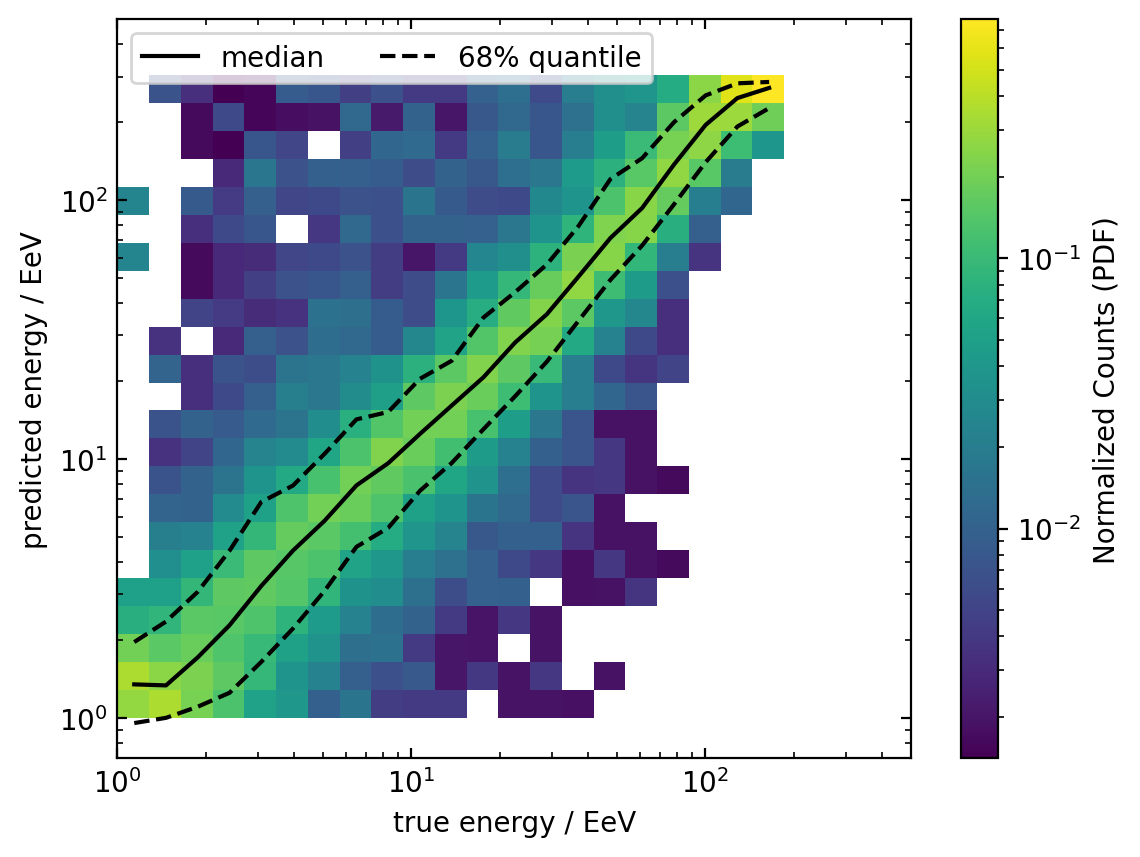

In [13]:
test_outputs = evaluate_cosmic_ray_model(model, X_test, y_test, criterion)

# plot results
bins = np.geomspace(1, 500, 26,endpoint=True)
x = torch.exp(test_outputs).cpu()
y = torch.exp(y_test).cpu() # get energy not in log

# Calculate counts for each hexagon
counts, xedges, yedges = np.histogram2d(x, y, bins=(bins, bins))

# Initialize normalized_counts
normalized_counts = np.zeros_like(counts, dtype=float)

# Perform linear normalization
for i in range(counts.shape[0]):
    max_count = np.sum(counts[i, :]) # loop over row
    if max_count > 0:
        normalized_counts[i, :] = counts[i, :] / max_count

# Calculate median y for each x-bin
median_y_per_xbin = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        median_y_per_xbin[i] = np.median(y_in_xbin)
    else:
        median_y_per_xbin[i] = np.nan  # Assign NaN if no y values fall in the bin

# Initialize arrays for the 16th and 84th percentiles for each x-bin
y_16th_quantile = np.zeros(len(bins) - 1)
y_84th_quantile = np.zeros(len(bins) - 1)

# Calculate the 16th and 84th percentiles for each x-bin
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        y_16th_quantile[i] = np.percentile(y_in_xbin, 16)
        y_84th_quantile[i] = np.percentile(y_in_xbin, 84)
    else:
        y_16th_quantile[i] = np.nan  # Assign NaN if no y values fall in the bin
        y_84th_quantile[i] = np.nan


fig, ax = plt.subplots()

# plot median
x_bin_mids = (bins[:-1] + bins[1:]) / 2
plt.plot(x_bin_mids,median_y_per_xbin,color='black',label ='median')
plt.plot(x_bin_mids, y_16th_quantile, color='black', ls='--', label=r'68% quantile')
plt.plot(x_bin_mids, y_84th_quantile, color='black', ls='--')

# Create meshgrid for X and Y
X, Y = np.meshgrid(xedges, yedges, indexing='xy')  # Ensure proper indexing

# Plot the hexbin with normalized counts directly
pc = ax.pcolormesh(X, Y, normalized_counts.T, shading='auto',norm=LogNorm())  # Transpose normalized_counts for correct shape

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label('Normalized Counts (PDF)')

# Set scales and labels
# Configure yedges and scales based on ylabel

ax.set_xlabel("true energy / EeV")
ax.set_ylabel("predicted energy / EeV")
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper left',ncol=2)


# Minor ticks and axis configuration
ax.minorticks_on()
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)


The model is not optimal for our problem. The prediction is the same for each event. Hence, the network does not learn, which can be observed in the loss function figure. 

Potential reasons:
* non-optimal network architecture
* non-optimal learning rate
* network might not be complex enough
* too few events for training

b) Multilayer-perceptron

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # Define the architecture of the MLP
        self.fc1 = nn.Linear(2 * 7 * 7, 256)  # Flattened input: [2, 7, 7] -> 2*7*7
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)  # Output: single energy value

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input from [batch_size, 2, 7, 7] to [batch_size, 2*7*7]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)  # Final layer (output energy prediction)
        x = x.squeeze()
        return x

  0%|          | 0/30 [00:00<?, ?it/s]

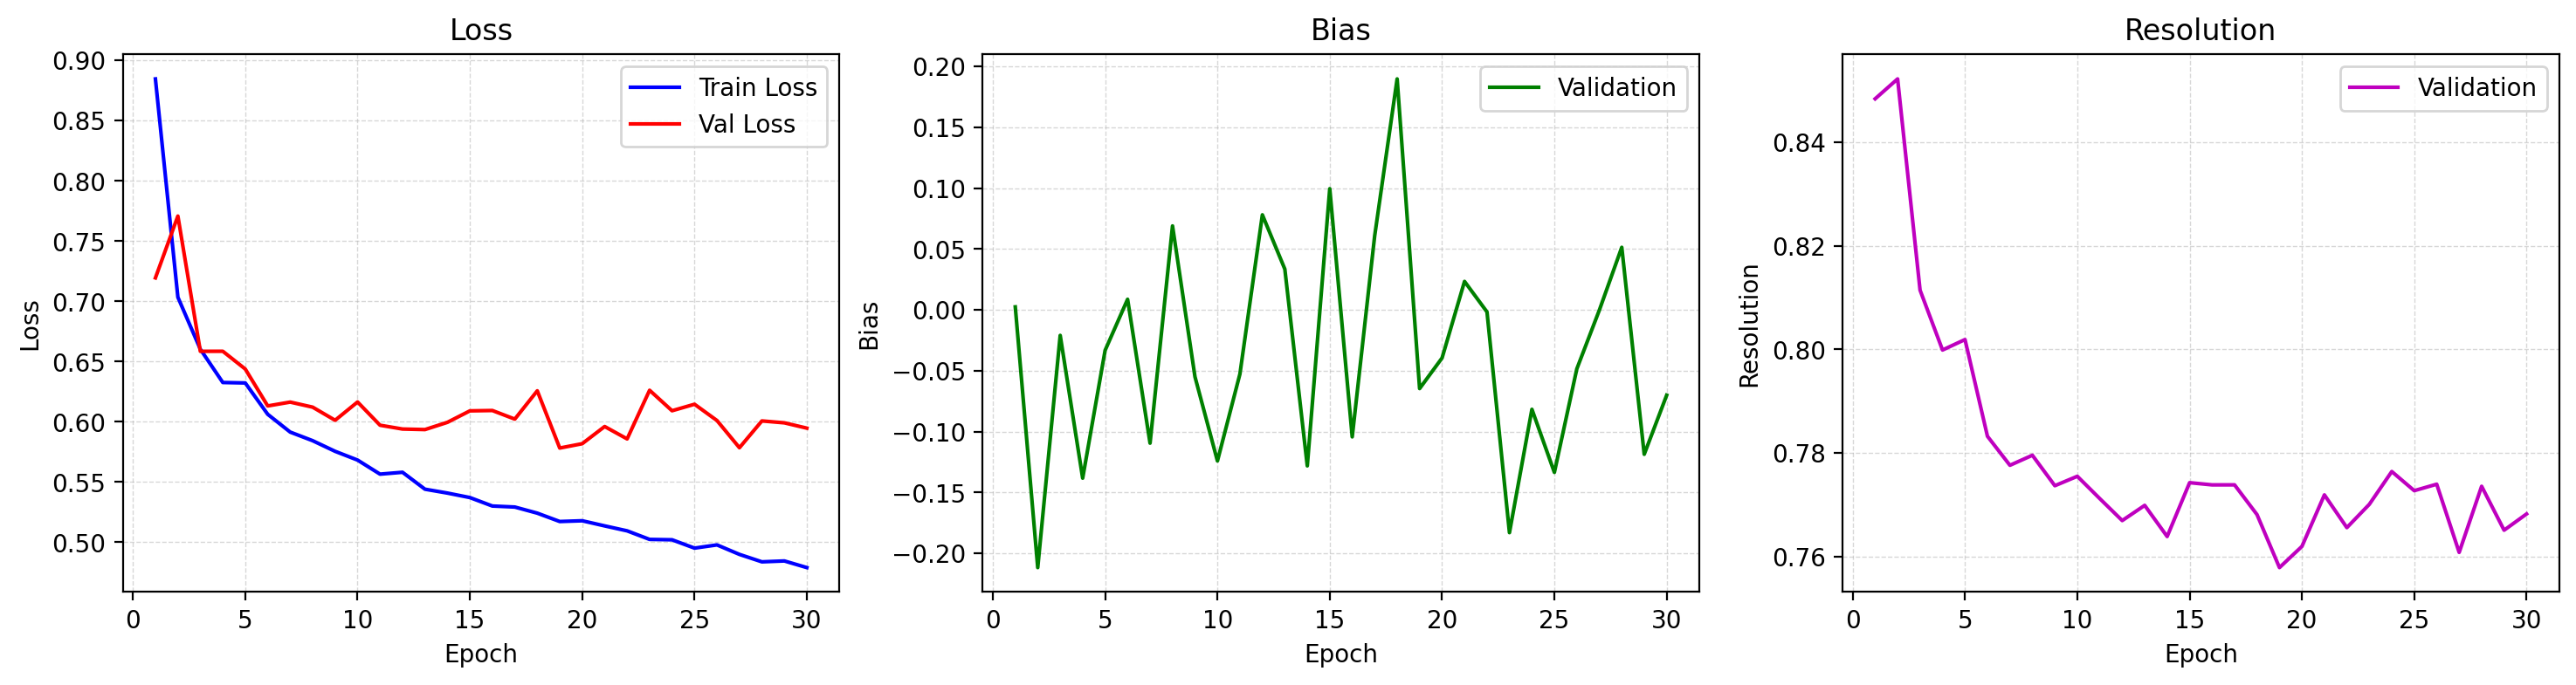

|       Epoch        |     Train loss     |  Validation loss   |        Bias        |     Resolution     |
__________________________________________________________________________________________________________


Epoch 1/30:   3%|▎         | 1/30 [00:02<01:14,  2.57s/it]

|         1          |       0.8846       |       0.7195       |        0.0024       |        0.8484       |


Epoch 2/30:   7%|▋         | 2/30 [00:04<01:09,  2.48s/it]

|         2          |       0.7034       |       0.7708       |       -0.2117       |        0.8522       |


Epoch 3/30:  10%|█         | 3/30 [00:07<01:06,  2.46s/it]

|         3          |       0.6603       |       0.6585       |       -0.0210       |        0.8114       |


Epoch 4/30:  13%|█▎        | 4/30 [00:09<01:03,  2.43s/it]

|         4          |       0.6327       |       0.6586       |       -0.1382       |        0.7999       |


Epoch 5/30:  17%|█▋        | 5/30 [00:12<01:00,  2.41s/it]

|         5          |       0.6323       |       0.6438       |       -0.0332       |        0.8019       |


Epoch 6/30:  20%|██        | 6/30 [00:14<00:57,  2.41s/it]

|         6          |       0.6063       |       0.6132       |        0.0087       |        0.7832       |


Epoch 7/30:  23%|██▎       | 7/30 [00:17<00:55,  2.41s/it]

|         7          |       0.5915       |       0.6164       |       -0.1095       |        0.7776       |


Epoch 8/30:  27%|██▋       | 8/30 [00:19<00:52,  2.40s/it]

|         8          |       0.5844       |       0.6122       |        0.0689       |        0.7795       |


Epoch 9/30:  30%|███       | 9/30 [00:21<00:50,  2.40s/it]

|         9          |       0.5755       |       0.6013       |       -0.0550       |        0.7737       |


Epoch 10/30:  33%|███▎      | 10/30 [00:24<00:47,  2.40s/it]

|         10         |       0.5683       |       0.6165       |       -0.1241       |        0.7755       |


Epoch 11/30:  37%|███▋      | 11/30 [00:26<00:45,  2.40s/it]

|         11         |       0.5566       |       0.5972       |       -0.0527       |        0.7712       |


Epoch 12/30:  40%|████      | 12/30 [00:28<00:43,  2.40s/it]

|         12         |       0.5581       |       0.5940       |        0.0781       |        0.7669       |


Epoch 13/30:  43%|████▎     | 13/30 [00:31<00:40,  2.40s/it]

|         13         |       0.5441       |       0.5936       |        0.0335       |        0.7699       |


Epoch 14/30:  47%|████▋     | 14/30 [00:33<00:38,  2.39s/it]

|         14         |       0.5409       |       0.5996       |       -0.1281       |        0.7638       |


Epoch 15/30:  50%|█████     | 15/30 [00:36<00:36,  2.42s/it]

|         15         |       0.5372       |       0.6091       |        0.0995       |        0.7742       |


Epoch 16/30:  53%|█████▎    | 16/30 [00:38<00:33,  2.40s/it]

|         16         |       0.5301       |       0.6094       |       -0.1043       |        0.7738       |


Epoch 17/30:  57%|█████▋    | 17/30 [00:40<00:31,  2.40s/it]

|         17         |       0.5293       |       0.6023       |        0.0608       |        0.7738       |


Epoch 18/30:  60%|██████    | 18/30 [00:43<00:28,  2.39s/it]

|         18         |       0.5242       |       0.6258       |        0.1897       |        0.7681       |


Epoch 19/30:  63%|██████▎   | 19/30 [00:45<00:26,  2.39s/it]

|         19         |       0.5173       |       0.5783       |       -0.0647       |        0.7578       |


Epoch 20/30:  67%|██████▋   | 20/30 [00:48<00:23,  2.38s/it]

|         20         |       0.5179       |       0.5819       |       -0.0395       |        0.7619       |


Epoch 21/30:  70%|███████   | 21/30 [00:50<00:21,  2.39s/it]

|         21         |       0.5136       |       0.5961       |        0.0234       |        0.7719       |


Epoch 22/30:  73%|███████▎  | 22/30 [00:52<00:19,  2.38s/it]

|         22         |       0.5095       |       0.5858       |       -0.0017       |        0.7656       |


Epoch 23/30:  77%|███████▋  | 23/30 [00:55<00:16,  2.38s/it]

|         23         |       0.5024       |       0.6262       |       -0.1830       |        0.7701       |


Epoch 24/30:  80%|████████  | 24/30 [00:57<00:14,  2.38s/it]

|         24         |       0.5021       |       0.6092       |       -0.0817       |        0.7764       |


Epoch 25/30:  83%|████████▎ | 25/30 [01:00<00:11,  2.38s/it]

|         25         |       0.4952       |       0.6146       |       -0.1335       |        0.7727       |


Epoch 26/30:  87%|████████▋ | 26/30 [01:02<00:09,  2.39s/it]

|         26         |       0.4979       |       0.6011       |       -0.0484       |        0.7739       |


Epoch 27/30:  90%|█████████ | 27/30 [01:04<00:07,  2.44s/it]

|         27         |       0.4900       |       0.5785       |       -0.0003       |        0.7608       |


Epoch 28/30:  93%|█████████▎| 28/30 [01:07<00:05,  2.50s/it]

|         28         |       0.4838       |       0.6008       |        0.0514       |        0.7735       |


Epoch 29/30:  97%|█████████▋| 29/30 [01:10<00:02,  2.55s/it]

|         29         |       0.4845       |       0.5992       |       -0.1186       |        0.7651       |


Epoch 30/30: 100%|██████████| 30/30 [01:13<00:00,  2.44s/it]

|         30         |       0.4790       |       0.5948       |       -0.0701       |        0.7682       |


In [15]:
model = MLP().to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, train_loader, test_loader)

Test Loss: 0.5950


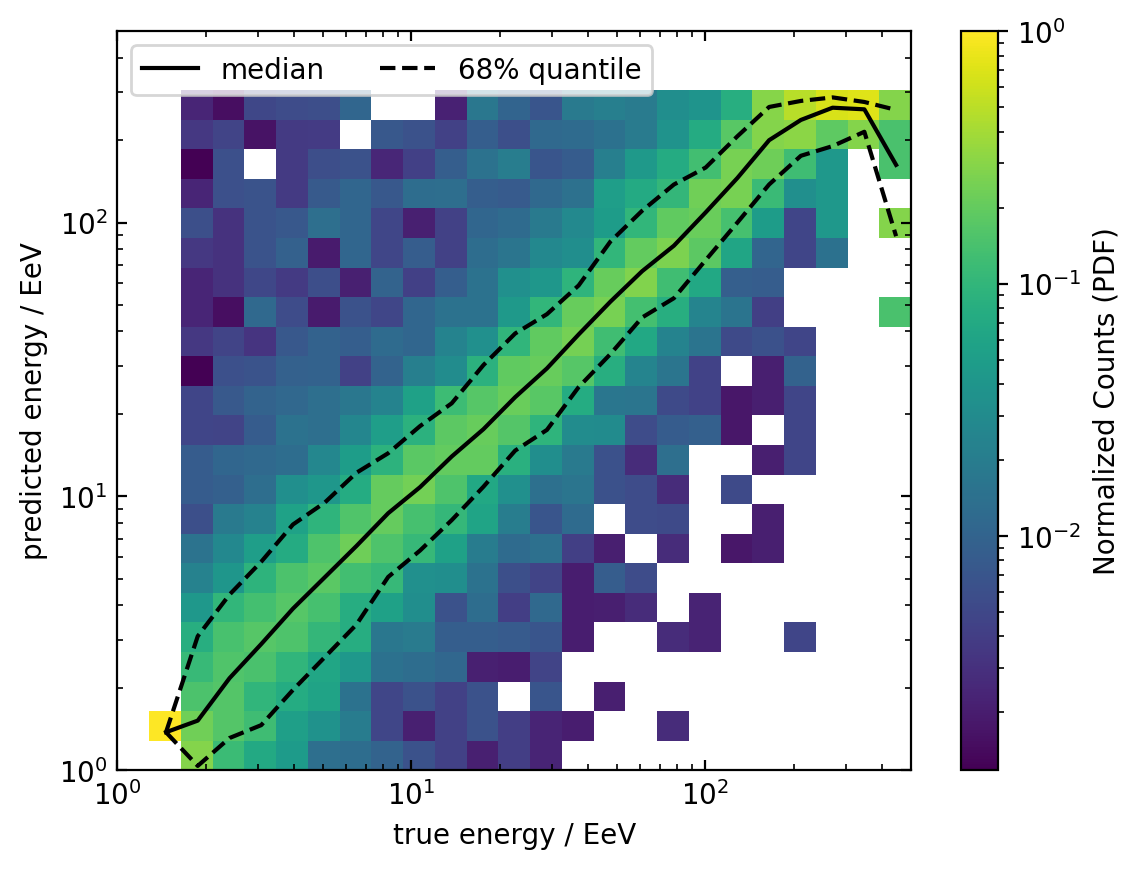

In [16]:
test_outputs = evaluate_cosmic_ray_model(model, X_test, y_test, criterion)

# Optional: plot the predicted vs. actual energy values

# plot results
bins = np.geomspace(1, 500, 26,endpoint=True)
x = torch.exp(test_outputs).cpu()
y = torch.exp(y_test).cpu() # get energy not in log

# Calculate counts for each hexagon
counts, xedges, yedges = np.histogram2d(x, y, bins=(bins, bins))

# Initialize normalized_counts
normalized_counts = np.zeros_like(counts, dtype=float)

# Perform linear normalization
for i in range(counts.shape[0]):
    max_count = np.sum(counts[i, :]) # loop over row
    if max_count > 0:
        normalized_counts[i, :] = counts[i, :] / max_count

# Calculate median y for each x-bin
median_y_per_xbin = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        median_y_per_xbin[i] = np.median(y_in_xbin)
    else:
        median_y_per_xbin[i] = np.nan  # Assign NaN if no y values fall in the bin

# Initialize arrays for the 16th and 84th percentiles for each x-bin
y_16th_quantile = np.zeros(len(bins) - 1)
y_84th_quantile = np.zeros(len(bins) - 1)

# Calculate the 16th and 84th percentiles for each x-bin
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        y_16th_quantile[i] = np.percentile(y_in_xbin, 16)
        y_84th_quantile[i] = np.percentile(y_in_xbin, 84)
    else:
        y_16th_quantile[i] = np.nan  # Assign NaN if no y values fall in the bin
        y_84th_quantile[i] = np.nan


fig, ax = plt.subplots()

# plot median
x_bin_mids = (bins[:-1] + bins[1:]) / 2
plt.plot(x_bin_mids,median_y_per_xbin,color='black',label ='median')
plt.plot(x_bin_mids, y_16th_quantile, color='black', ls='--', label=r'68% quantile')
plt.plot(x_bin_mids, y_84th_quantile, color='black', ls='--')

# Create meshgrid for X and Y
X, Y = np.meshgrid(xedges, yedges, indexing='xy')  # Ensure proper indexing

# Plot the hexbin with normalized counts directly
pc = ax.pcolormesh(X, Y, normalized_counts.T, shading='auto',norm=LogNorm())  # Transpose normalized_counts for correct shape

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label('Normalized Counts (PDF)')

# Set scales and labels
# Configure yedges and scales based on ylabel

ax.set_xlabel("true energy / EeV")
ax.set_ylabel("predicted energy / EeV")
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper left',ncol=2)


# Minor ticks and axis configuration
ax.minorticks_on()
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)

The prediction is still constant and the model does not learn.

c) Simple CNN

In [17]:
class CosmicRayCNN(nn.Module):
    def __init__(self):
        super(CosmicRayCNN, self).__init__()
        
        # Define a 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers after convolution
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # 32 channels, 7x7 image after conv layers
        self.fc2 = nn.Linear(64, 1)  # Output layer for regression (1 target: energy)

    def forward(self, x):
        # Convolutional layers with ReLU activations
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Flatten the output from conv layers to feed into fully connected layers
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 32*7*7)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer (no activation for regression)
        
        return x.squeeze()

  0%|          | 0/30 [00:00<?, ?it/s]

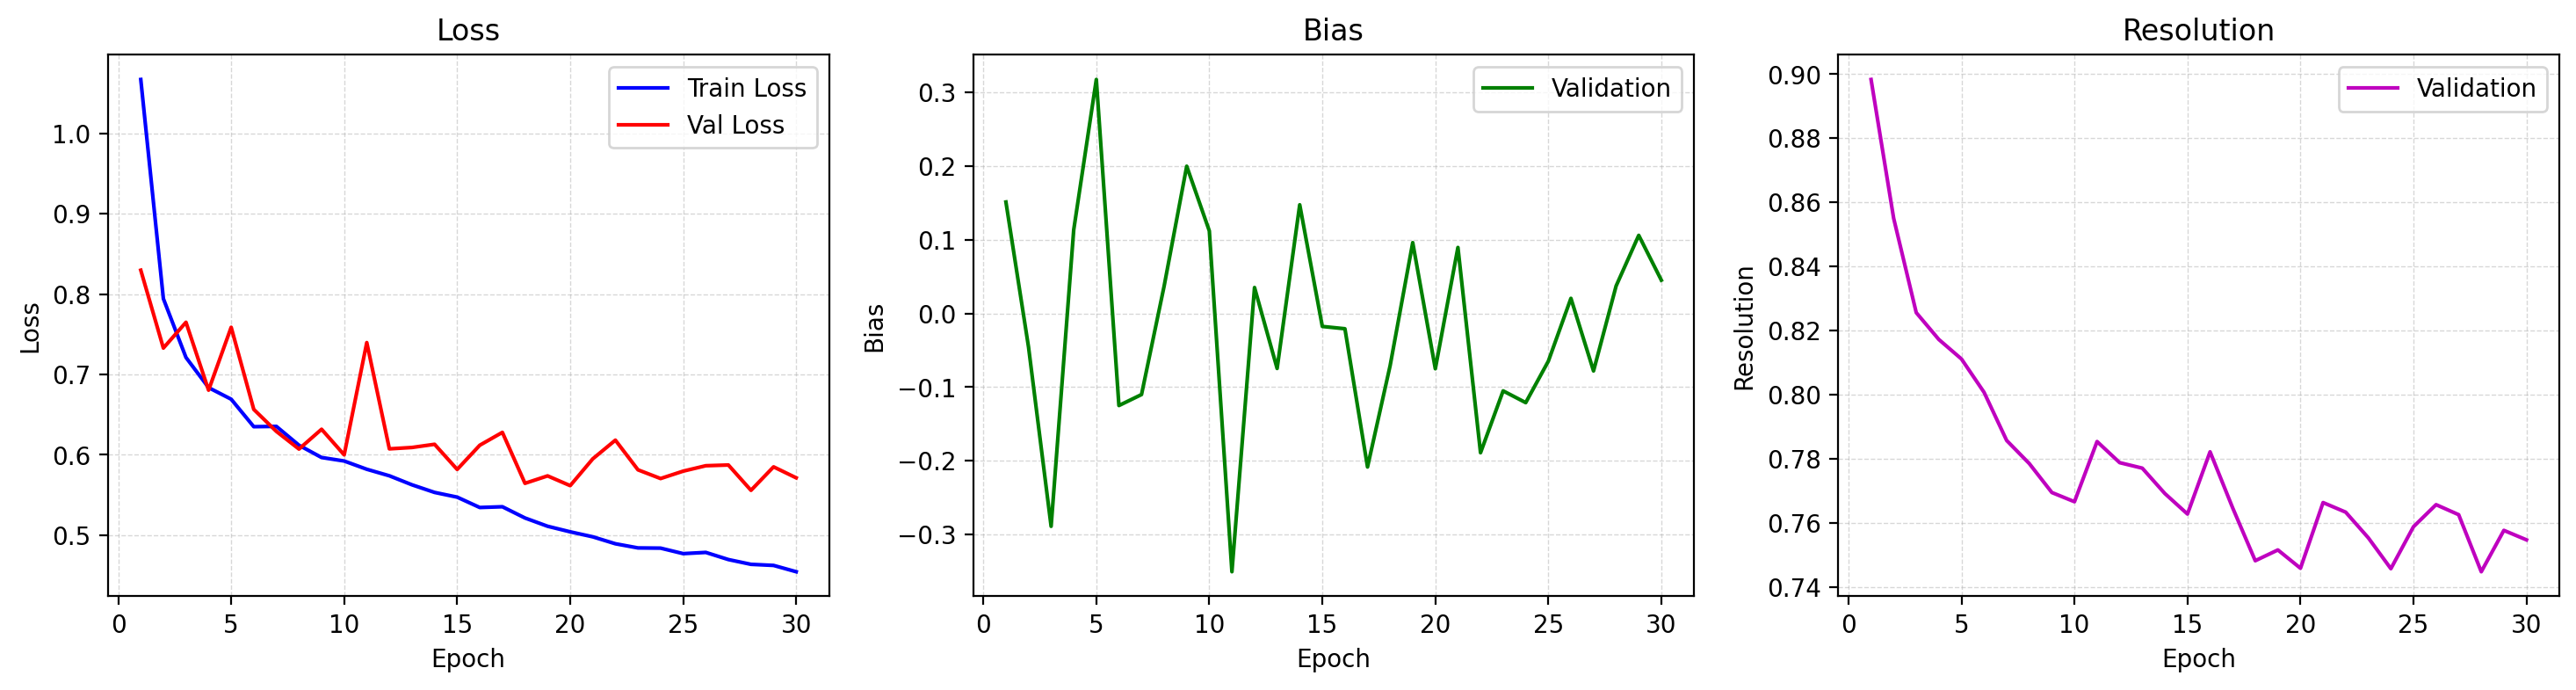

|       Epoch        |     Train loss     |  Validation loss   |        Bias        |     Resolution     |
__________________________________________________________________________________________________________


Epoch 1/30:   3%|▎         | 1/30 [00:03<01:31,  3.17s/it]

|         1          |       1.0668       |       0.8296       |        0.1513       |        0.8983       |


Epoch 2/30:   7%|▋         | 2/30 [00:05<01:22,  2.95s/it]

|         2          |       0.7942       |       0.7328       |       -0.0456       |        0.8550       |


Epoch 3/30:  10%|█         | 3/30 [00:08<01:18,  2.92s/it]

|         3          |       0.7211       |       0.7649       |       -0.2892       |        0.8256       |


Epoch 4/30:  13%|█▎        | 4/30 [00:11<01:15,  2.90s/it]

|         4          |       0.6836       |       0.6804       |        0.1135       |        0.8172       |


Epoch 5/30:  17%|█▋        | 5/30 [00:14<01:13,  2.92s/it]

|         5          |       0.6692       |       0.7586       |        0.3177       |        0.8111       |


Epoch 6/30:  20%|██        | 6/30 [00:17<01:09,  2.90s/it]

|         6          |       0.6350       |       0.6565       |       -0.1252       |        0.8007       |


Epoch 7/30:  23%|██▎       | 7/30 [00:20<01:06,  2.90s/it]

|         7          |       0.6354       |       0.6292       |       -0.1102       |        0.7857       |


Epoch 8/30:  27%|██▋       | 8/30 [00:23<01:03,  2.88s/it]

|         8          |       0.6120       |       0.6072       |        0.0371       |        0.7785       |


Epoch 9/30:  30%|███       | 9/30 [00:26<01:00,  2.90s/it]

|         9          |       0.5967       |       0.6318       |        0.1999       |        0.7695       |


Epoch 10/30:  33%|███▎      | 10/30 [00:29<00:58,  2.94s/it]

|         10         |       0.5923       |       0.6000       |        0.1120       |        0.7666       |


Epoch 11/30:  37%|███▋      | 11/30 [00:32<00:55,  2.93s/it]

|         11         |       0.5821       |       0.7396       |       -0.3508       |        0.7854       |


Epoch 12/30:  40%|████      | 12/30 [00:35<00:52,  2.93s/it]

|         12         |       0.5740       |       0.6075       |        0.0351       |        0.7788       |


Epoch 13/30:  43%|████▎     | 13/30 [00:37<00:49,  2.92s/it]

|         13         |       0.5628       |       0.6092       |       -0.0748       |        0.7771       |


Epoch 14/30:  47%|████▋     | 14/30 [00:40<00:46,  2.88s/it]

|         14         |       0.5533       |       0.6131       |        0.1475       |        0.7692       |


Epoch 15/30:  50%|█████     | 15/30 [00:43<00:42,  2.86s/it]

|         15         |       0.5474       |       0.5819       |       -0.0177       |        0.7628       |


Epoch 16/30:  53%|█████▎    | 16/30 [00:46<00:40,  2.86s/it]

|         16         |       0.5345       |       0.6120       |       -0.0208       |        0.7822       |


Epoch 17/30:  57%|█████▋    | 17/30 [00:49<00:36,  2.83s/it]

|         17         |       0.5355       |       0.6280       |       -0.2086       |        0.7647       |


Epoch 18/30:  60%|██████    | 18/30 [00:52<00:34,  2.86s/it]

|         18         |       0.5215       |       0.5646       |       -0.0710       |        0.7482       |


Epoch 19/30:  63%|██████▎   | 19/30 [00:54<00:31,  2.84s/it]

|         19         |       0.5112       |       0.5739       |        0.0961       |        0.7516       |


Epoch 20/30:  67%|██████▋   | 20/30 [00:57<00:28,  2.85s/it]

|         20         |       0.5043       |       0.5617       |       -0.0752       |        0.7459       |


Epoch 21/30:  70%|███████   | 21/30 [01:00<00:25,  2.84s/it]

|         21         |       0.4981       |       0.5950       |        0.0895       |        0.7663       |


Epoch 22/30:  73%|███████▎  | 22/30 [01:03<00:22,  2.83s/it]

|         22         |       0.4894       |       0.6183       |       -0.1893       |        0.7634       |


Epoch 23/30:  77%|███████▋  | 23/30 [01:06<00:19,  2.83s/it]

|         23         |       0.4843       |       0.5814       |       -0.1052       |        0.7554       |


Epoch 24/30:  80%|████████  | 24/30 [01:09<00:16,  2.82s/it]

|         24         |       0.4840       |       0.5705       |       -0.1212       |        0.7457       |


Epoch 25/30:  83%|████████▎ | 25/30 [01:11<00:14,  2.84s/it]

|         25         |       0.4772       |       0.5798       |       -0.0649       |        0.7588       |


Epoch 26/30:  87%|████████▋ | 26/30 [01:14<00:11,  2.83s/it]

|         26         |       0.4787       |       0.5865       |        0.0204       |        0.7657       |


Epoch 27/30:  90%|█████████ | 27/30 [01:17<00:08,  2.84s/it]

|         27         |       0.4698       |       0.5874       |       -0.0782       |        0.7626       |


Epoch 28/30:  93%|█████████▎| 28/30 [01:20<00:05,  2.84s/it]

|         28         |       0.4639       |       0.5559       |        0.0373       |        0.7448       |


Epoch 29/30:  97%|█████████▋| 29/30 [01:23<00:02,  2.84s/it]

|         29         |       0.4625       |       0.5851       |        0.1060       |        0.7577       |


Epoch 30/30: 100%|██████████| 30/30 [01:26<00:00,  2.88s/it]

|         30         |       0.4547       |       0.5714       |        0.0451       |        0.7547       |


In [18]:
model = CosmicRayCNN().to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, train_loader, test_loader)

Test Loss: 0.5716


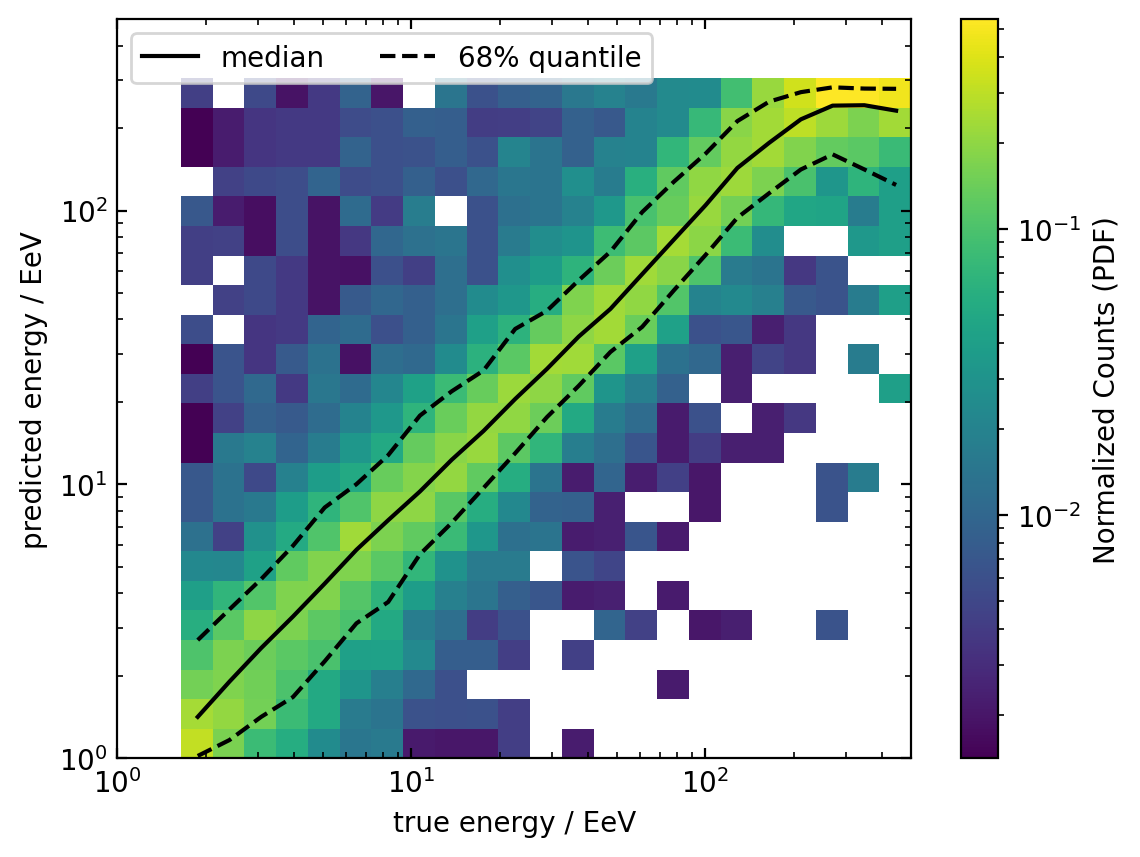

In [19]:
test_outputs = evaluate_cosmic_ray_model(model, X_test, y_test, criterion)

# Optional: plot the predicted vs. actual energy values

# plot results
bins = np.geomspace(1, 500, 26,endpoint=True)
x = torch.exp(test_outputs).cpu()
y = torch.exp(y_test).cpu() # get energy not in log

# Calculate counts for each hexagon
counts, xedges, yedges = np.histogram2d(x, y, bins=(bins, bins))

# Initialize normalized_counts
normalized_counts = np.zeros_like(counts, dtype=float)

# Perform linear normalization
for i in range(counts.shape[0]):
    max_count = np.sum(counts[i, :]) # loop over row
    if max_count > 0:
        normalized_counts[i, :] = counts[i, :] / max_count

# Calculate median y for each x-bin
median_y_per_xbin = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        median_y_per_xbin[i] = np.median(y_in_xbin)
    else:
        median_y_per_xbin[i] = np.nan  # Assign NaN if no y values fall in the bin

# Initialize arrays for the 16th and 84th percentiles for each x-bin
y_16th_quantile = np.zeros(len(bins) - 1)
y_84th_quantile = np.zeros(len(bins) - 1)

# Calculate the 16th and 84th percentiles for each x-bin
for i in range(len(bins) - 1):
    y_in_xbin = y[(x >= bins[i]) & (x < bins[i + 1])]
    if len(y_in_xbin) > 0:
        y_16th_quantile[i] = np.percentile(y_in_xbin, 16)
        y_84th_quantile[i] = np.percentile(y_in_xbin, 84)
    else:
        y_16th_quantile[i] = np.nan  # Assign NaN if no y values fall in the bin
        y_84th_quantile[i] = np.nan


fig, ax = plt.subplots()

# plot median
x_bin_mids = (bins[:-1] + bins[1:]) / 2
plt.plot(x_bin_mids,median_y_per_xbin,color='black',label ='median')
plt.plot(x_bin_mids, y_16th_quantile, color='black', ls='--', label=r'68% quantile')
plt.plot(x_bin_mids, y_84th_quantile, color='black', ls='--')

# Create meshgrid for X and Y
X, Y = np.meshgrid(xedges, yedges, indexing='xy')  # Ensure proper indexing

# Plot the hexbin with normalized counts directly
pc = ax.pcolormesh(X, Y, normalized_counts.T, shading='auto',norm=LogNorm())  # Transpose normalized_counts for correct shape

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label('Normalized Counts (PDF)')

# Set scales and labels
# Configure yedges and scales based on ylabel

ax.set_xlabel("true energy / EeV")
ax.set_ylabel("predicted energy / EeV")
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper left',ncol=2)


# Minor ticks and axis configuration
ax.minorticks_on()
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)

This model predicts the energy better than the previous one. We can observe a linear trend, but still see many wrong predictions. More time and complex models are required to solve real-life problems, such as the energy reconstruction of a cosmic ray experiment.

#### Take-home for application on real data

Today we only trained a network on simulated data and will not apply such a network to real, unknown data. Before a model can be applied to real-life data, we need to do certain robustness checks to account for deviations of the real-life physics to our simulation (what we know and can predict). 

* If the training on simulated data works sufficiently well, we need to ensure the model is applicable to data that can deviate within a certain range from the simulation. This is often tested by simulating a quantity from different models or artificial variation within certain value ranges. The model should perform sufficiently well on these simulated data sets as well.

* The data-simulation-agreement needs to be sufficiently well for the estimator quantities. Deviations in the feature can lead to wrong predictions.

* Proper handling of training, test and validation set. Hyperparameter of a model are optimized using a second set that tests the performs. At the very last step, the optimized model is evaluated on a third set.
